In [1]:
import matplotlib.pyplot as plt
import numpy as np
from ase import io
import shutil
import plumed
import os

# Creating startpoints

This PLUMED notebook shows how I generated a series of startpoints for the isocommittor simulations that you use in the exercise on path collective variables.   I did this by running a short gromacs simulation in which the system was forced to stay close to the center of the range of possible values for $\psi.$

## Some initial experiments with PLUMED

I had the initial configuration of PLUMED that is given in the following gro file.  As you can see from the PLUMED calclation below this configuration is close to the transition state. 

In [2]:
grofile='''ALANINE DIPEPTIDE
   22
    1ALAD    CL    1  -0.807   0.271   0.200 -0.0809 -0.4214 -0.6604
    1ALAD   HL1    2  -0.783   0.337   0.114  1.5179  1.4736  1.1166
    1ALAD   HL2    3  -0.768   0.169   0.177  1.1467  0.1532 -1.2237
    1ALAD   HL3    4  -0.917   0.254   0.204 -0.4669  1.9955  1.0426
    1ALAD   CLP    5  -0.760   0.330   0.321 -0.1548  0.1214 -0.6060
    1ALAD    OL    6  -0.653   0.298   0.372  0.3778 -0.0659  0.5648
    1ALAD    NL    7  -0.842   0.425   0.380 -0.0921  0.3235  0.0565
    1ALAD    HL    8  -0.931   0.442   0.339 -0.7429  0.2116  1.3716
    1ALAD    CA    9  -0.816   0.508   0.496 -0.4318 -0.3565  0.2818
    1ALAD    HA   10  -0.804   0.607   0.453 -0.8483 -0.0098  0.9549
    1ALAD    CB   11  -0.944   0.535   0.577  0.1563 -0.2172  0.3083
    1ALAD   HB1   12  -0.924   0.609   0.658  1.8041 -0.9057  0.5868
    1ALAD   HB2   13  -1.028   0.572   0.515 -0.3299 -1.9452 -0.1084
    1ALAD   HB3   14  -0.974   0.443   0.632  2.0042 -0.5496  0.8587
    1ALAD   CRP   15  -0.700   0.493   0.591  0.7662  0.4496 -0.2435
    1ALAD    OR   16  -0.618   0.583   0.618  0.1238 -0.2178 -0.5837
    1ALAD    NR   17  -0.688   0.376   0.652 -0.8670  0.2125  0.2422
    1ALAD    HR   18  -0.751   0.303   0.626 -2.1243  0.9671  1.0091
    1ALAD    CR   19  -0.586   0.353   0.750 -0.0690  0.0127 -0.1022
    1ALAD   HR1   20  -0.505   0.428   0.748  1.3345 -1.1470  4.0201
    1ALAD   HR2   21  -0.620   0.356   0.856 -0.7803  1.2050 -0.3380
    1ALAD   HR3   22  -0.539   0.255   0.731  0.6349  0.5075 -0.9622
   3.71000   3.71000   3.71000'''

Read above input into NumPy arrays:

In [3]:
myfile = grofile.split()
natoms = int(myfile[2])
pos = np.zeros([natoms,3], dtype=np.float64)
for i in range(natoms) :
    pos[i,0] = myfile[2 + i*9 + 4]
    pos[i,1] = myfile[2 + i*9 + 5]
    pos[i,2] = myfile[2 + i*9 + 6]

box = np.array([[myfile[-3],0,0],[0,myfile[-2],0],[0,0,myfile[-1]]], dtype=np.float64 )

Lets quickly calculate the value of $\psi\$ for the configuration above using PLUMED:

In [4]:
p = plumed.Plumed()
p.cmd("setMDEngine","python")
# Read PDB so units are 0.1 nm
p.cmd("setTimestep", 1.)
p.cmd("setKbT", 1.)
p.cmd("setNatoms",natoms)
p.cmd("setLogFile","test.log")
p.cmd("init")
# Read in the PATH coordinate and create the shared memory
p.cmd("readInputLine", "phi: TORSION ATOMS=5,7,9,15")
shape = np.zeros( 1, dtype=np.int_ )
p.cmd("getDataRank phi", shape )
phi = np.zeros((1))
p.cmd("setMemoryForData phi", phi )
# Now do the calculation with PLUMED
p.cmd("setStep",1)
p.cmd("setBox",box )
masses = np.zeros(natoms,dtype=np.float64)
p.cmd("setMasses", masses )
charges = np.zeros(natoms,dtype=np.float64)
p.cmd("setCharges", charges ) 
p.cmd("setPositions", pos )
forces = np.zeros([natoms,3])
p.cmd("setForces", forces )
virial = np.zeros((3,3),dtype=np.float64)
p.cmd("setVirial", virial )
p.cmd("calc")

print("VALUE OF PHI", phi[0] )

VALUE OF PHI -0.17678176036892257


## Running the gromacs simulation

Below I have an input for PLUMED that puts a restraint so that we stay close to the transition state that is roughly at $\psi=0$.

In [9]:
plumedinpt = '''phi: TORSION ATOMS=5,7,9,15
RESTRAINT ARG=phi AT=0 KAPPA=100
PRINT ARG=phi FILE=colvar STRIDE=5000'''

Now we create some input for gromacs:

In [10]:
!rm -rf ../Trajectories/Create_midpoints
!mkdir ../Trajectories/Create_midpoints
# Copy the topology to the appropriate directory
shutil.copyfile("../data/topol.top","../Trajectories/Create_midpoints/topol.top")
# Setup the mdp file
mdp = open("../data/md.mdp","r")
contents = mdp.read()
mdp.close()
new_content = contents.replace("SEED", str(np.random.randint(0,1000000))).replace("NSTEPS","500000").replace("TEMP","300")
mdpout = open("../Trajectories/Create_midpoints/md.mdp", "w")
mdpout.write(new_content)
mdpout.close()
# Write out the configurtion
cout = open("../Trajectories/Create_midpoints/conf.gro", "w")
cout.write(grofile)
cout.close()
# And write the plumed input
pout = open("../Trajectories/Create_midpoints/plumed.dat", "w")
pout.write( plumedinpt )
pout.close()

We can now run gromacs

In [11]:
!cd ../Trajectories/Create_midpoints/ && gmx grompp -f md.mdp -c conf.gro -p topol.top &> /dev/null 
!cd ../Trajectories/Create_midpoints/ && gmx mdrun --plumed plumed.dat &> /dev/null

Lets now look at the values of $\psi$ that have been explored to see if they are all close to the transition state.

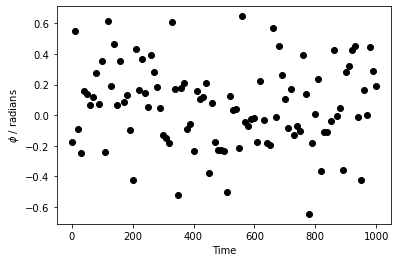

In [12]:
data = np.loadtxt('../Trajectories/Create_midpoints/colvar')
plt.plot( data[:,0], data[:,1], 'ko' )
plt.xlabel('Time')
plt.ylabel(r'$\phi$ / radians')
plt.show()

To create the startpoints.pdb file I loaded the  traj.trr file output from the calculation above into vmd and saved it as a pdb.